# Satelliteguard

![Vodnjan Logo](assets/vodnjan-logo.png)

## Detekcija nekretnina i obrađenih površina


image 1/1 c:\Users\josip\Documents\GitHub\edih-adria\vodnjan-satelliteguard\sample_images\2.png: 320x640 42 houses, 1 land, 187.3ms
Speed: 2.0ms preprocess, 187.3ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


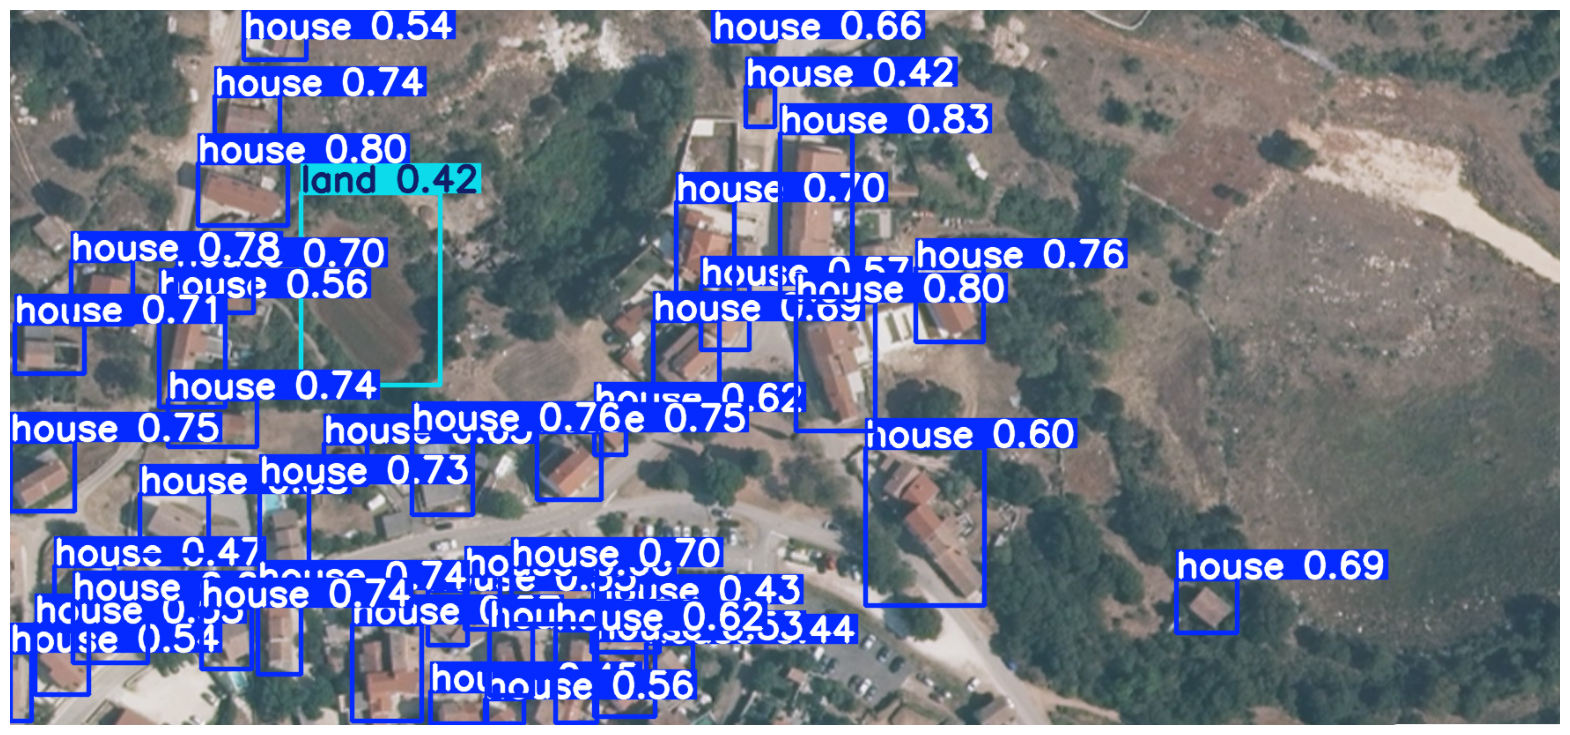

In [3]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2

model = YOLO(os.path.join("models", "satelliteguard-v8.pt"))

image_path = os.path.join("sample_images", "2.png")

results = model(image_path, conf=0.4)

original_image = Image.open(image_path)

for result in results:
    predicted_image = result.plot()
    predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10))
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

## Detekcija deponija otpada

In [64]:
import json
from PIL import Image, ImageDraw, ImageFont

def parse_json(json_output):
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """
    img = im
    width, height = img.size
    draw = ImageDraw.Draw(img)

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    for bounding_box in json.loads(bounding_boxes):
      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline="red", width=4
      )

      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill="red", font=ImageFont.load_default())

In [61]:
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
from io import BytesIO

load_dotenv()

def detect_garbage(image_path):
    # Load and resize image
    im = Image.open(BytesIO(open(image_path, "rb").read()))
    im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

    client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

    bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 1 object.
    If there is no object, return an empty array.
    """

    PROMPT = "Detect the 2d bounding boxes of garbage"

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(
            system_instruction= bounding_box_system_instructions,
            temperature=0.2,
        ),
        contents=[PROMPT, im])

    print(response.text)

    plot_bounding_boxes(im, response.text)
    return im

```json
[
  {"box_2d": [649, 601, 717, 682], "label": "garbage"}
]
```


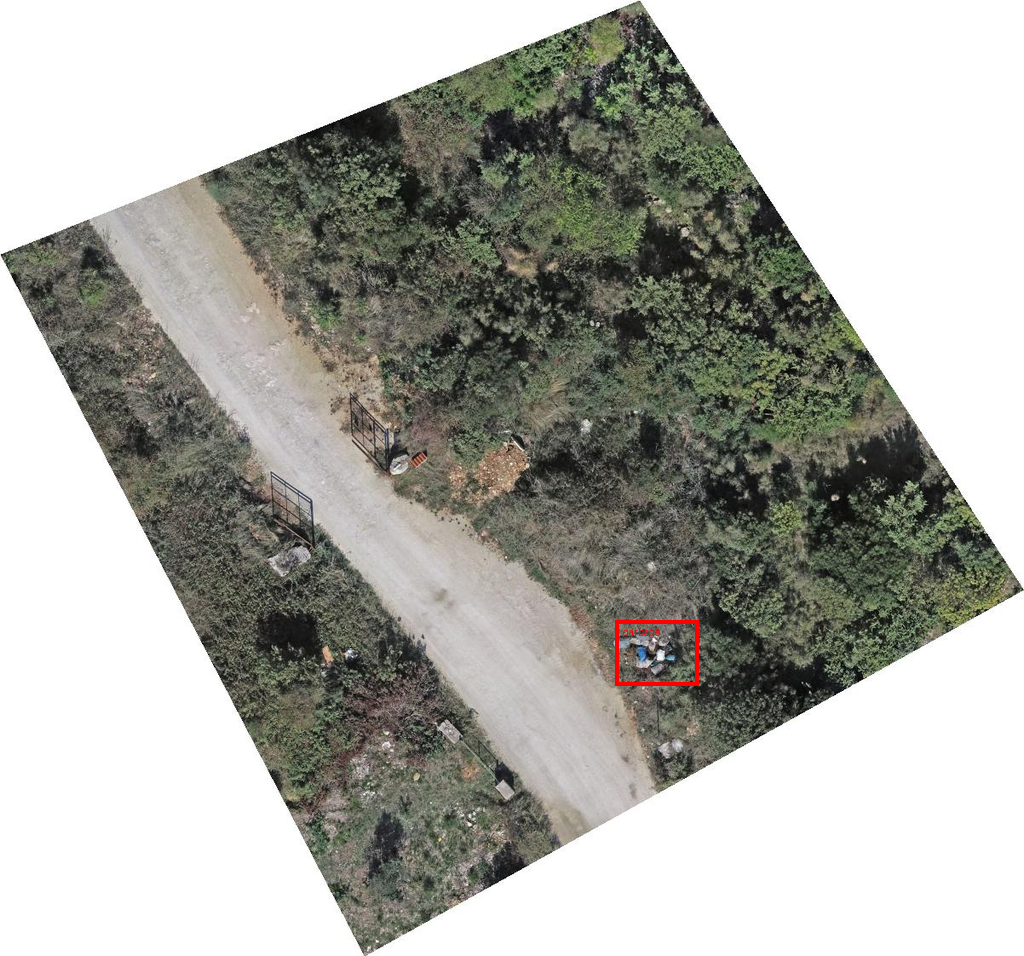

In [65]:
detect_garbage("sample_images/vodnjan_kamenolom.jpg")

[]


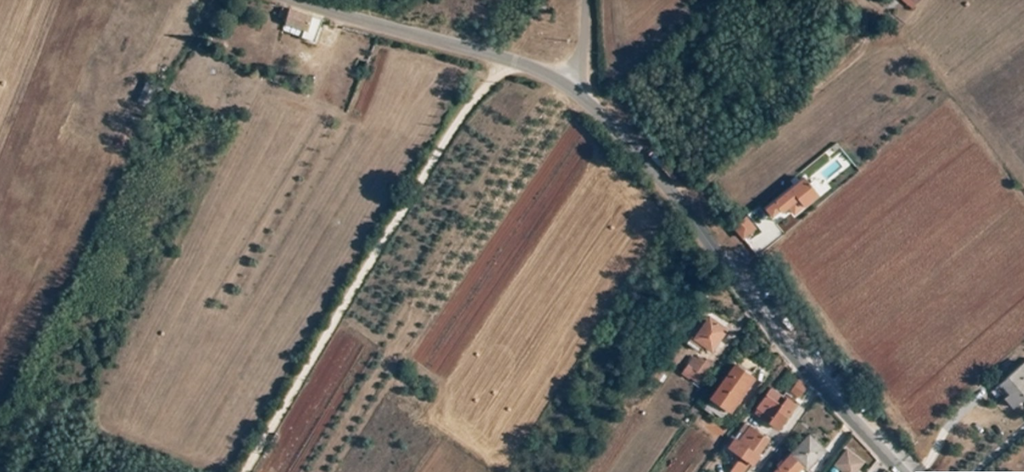

In [66]:
detect_garbage("sample_images/1.png")